<a href="https://colab.research.google.com/github/exesaLigno/ML-Lab-1/blob/main/Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Дисклеймер

Общее время выполнения всего блокнота составляет приблизительно **23 минуты** (больше при нестабильном соединении при установке библиотек и загрузке данных).

# Подготовка

In [1]:
!pip install python-mnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Получение задания

In [2]:
email = 'kartsev.vs@phystech.edu'

In [3]:
from zlib import crc32
import numpy as np
from pprint import pprint

types = ['regression', 'classification']
datasets = {'regression': [{'name': 'Servo Data Set', 'url': 'https://archive.ics.uci.edu/ml/datasets/Servo'}, 
                           {'name': 'Forest Fires Data Set', 'url': 'https://archive.ics.uci.edu/ml/datasets/Forest+Fires'},
                           {'name': 'Boston Housing Data Set', 'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston'}, 
                           {'name': 'Diabetes Data Set', 'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes'}],
            'classification': [{'name': 'Spambase Data Set', 'url': 'https://archive.ics.uci.edu/ml/datasets/Spambase'}, 
                               {'name': 'Wine Data Set', 'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine'}, 
                               {'name': 'Breast Cancer Data Set', 'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer'}, 
                               {'name': 'MNIST', 'url': 'http://yann.lecun.com/exdb/mnist/'}]}
methods = {'regression': ['Линейная регрессия', 'Перцептрон', 'Надарая-Ватсона', 'SVR'],
           'classification': ['Логистическая регрессия', 'Перцептрон', 'k-ближайших соседей', 'Метод потенциальных функций', 'Метод Парзеновского окна', 'SVM']}

task = dict()
task['mail'] = email
task['id'] = crc32(task['mail'].encode('utf-8'))
np.random.seed(task['id'])
task['type'] = np.random.choice(types)
task['dataset'] = np.random.choice(datasets[task['type']])
task['method'] = np.random.choice(
  methods[task['type']], size=3, replace=False).tolist()

pprint(task)

{'dataset': {'name': 'MNIST', 'url': 'http://yann.lecun.com/exdb/mnist/'},
 'id': 3425420873,
 'mail': 'kartsev.vs@phystech.edu',
 'method': ['Метод потенциальных функций',
            'k-ближайших соседей',
            'Логистическая регрессия'],
 'type': 'classification'}


## Импорт всего необходимого

In [4]:
import progressbar
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
import numpy as np

from torchvision import datasets
from torchvision import transforms

import torch

from scipy.spatial.distance import cdist
from mlxtend.plotting import plot_decision_regions
from datetime import datetime
from pprint import pprint
from progressbar.bar import ProgressBar

from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

При загрузке выборке скомпонируем преобразования Resize и ToTensor, чтобы уменьшить размер изображений и упростить процесс обучения для бесплатного коллаба.

In [5]:
train = datasets.MNIST('./mnist', train=True, download=True, 
                      transform=transforms.Compose([transforms.Resize([14,]), transforms.ToTensor()]))
test = datasets.MNIST('./mnist', train=False, download=True, 
                      transform=transforms.Compose([transforms.Resize([14,]), transforms.ToTensor()]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



## Структура датасета

Выборка представляет собой набор изображений с рукописными цифрами и ярлыками, соответствующими цифрам. 
Отобразим четыре случайных элемента выборки для ознакомления.

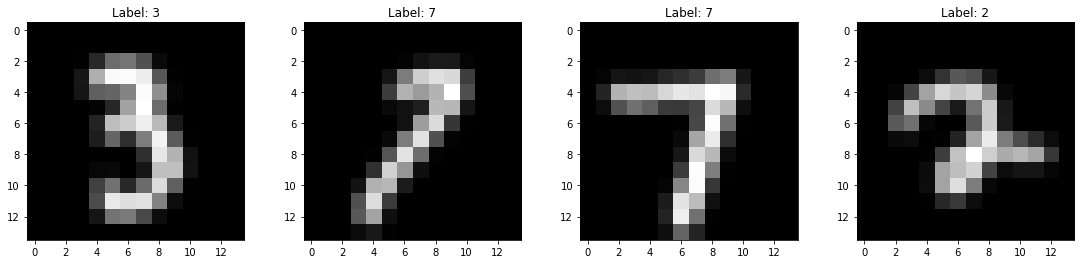

In [6]:
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

ax = []

for i in range(4):
  ax.append(fig.add_subplot(gs[i]))
  image_num = np.random.randint(0, 1000)
  ax[i].imshow(np.array(train[image_num][0][0]), 'gray')
  ax[i].title.set_text(f'Label: {train[image_num][1]}')

plt.show()

## Вспомогательные функции

Также напишем вспомогательные функции для отображения и анализа результатов.

In [7]:
def validate(model, test_X, test_Y, show_table = True):
  predicted_Y = model.predict(test_X)

  correct = 0
  errors = []

  results = [[0 for _ in range(10)] for _ in range(10)]
  for number, (predicted, real) in enumerate(zip(predicted_Y, test_Y)):
    if predicted == real: correct += 1
    else: errors.append({'label': real.item(), 'prediction': predicted, 'image': test_X[number]})
    results[predicted-1][real-1] += 1

  if show_table:
    print('labels:        0    1    2    3    4    5    6    7    8    9')
    for l in range(10):
      print(f'predicted {l} ', end='')
      for c in range(10):
        print(f'{results[l][c]:4d}', end = ' ')
      print()

  print(f'Correctness: {(correct / len(predicted_Y) * 100):.1f}%')

  return correct / len(predicted_Y) * 100, errors

def showErrors(error_list, error_count, random=True):
  fig, gs = plt.figure(figsize=(5*error_count,4)), gridspec.GridSpec(1, error_count)

  ax = []

  if random:
    errors = np.random.choice(error_list, error_count)
  else:
    errors = error_list[0:error_count]

  for i, error in enumerate(errors):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].imshow(np.array(error['image'].reshape(14,14)), 'gray')
    label = error['label']
    prediction = error['prediction']
    ax[i].title.set_text(f'{label} perceived as {prediction}')

  plt.show()

Создадим функции, преобразующие изображения в вектора признаков.

In [8]:
# Simple image tensor reshaping
def image2Vector(image):
  return image.reshape(1,-1)

#reshaping with converting to 'bool' with treshold
def image2BoolVector(image, treshold = 40):
  vector = image.reshape(1,-1)
  for i in range(len(vector[0])):
    vector[0][i] = 255 if vector[0][i] >= treshold else 0
  return vector

def image2VectorPCA(image):
  return None

def getPreparedDataset(dataset, selection=1, selection_start=0, converter=image2Vector):
  if converter.__name__ == 'image2VectorPCA':
    pca = PCA(196)
    return pca.fit_transform(dataset.data.view([-1, 784]).cpu().numpy()), dataset.targets.cpu().numpy()

  Y = []
  X = None

  for number, (image, label) in enumerate(dataset):
    if number % selection == selection_start:
      features = converter(image)
      if X == None:
        X = features
      else:
        X = torch.vstack((X, features))
      Y.append(label)

  Y = torch.tensor(Y)

  return X, Y

## Поиск подходящих конвертеров в признаки

Протестируем написанные функции перевода изображения в признаки, собрав небольшие обучающую и тренировочную выборки и обучив модель KNN на них.

In [9]:
featuresConverters = [image2Vector, image2BoolVector, image2VectorPCA]

max_correctness = 0
opt_converter = None

for converter in featuresConverters:
  print(f'{converter.__name__} converter:', end=' ')

  tiny_train_X, tiny_train_Y = getPreparedDataset(train, selection=50, converter=converter)
  tiny_test_X, tiny_test_Y = getPreparedDataset(test, selection=20, converter=converter)

  model = KNeighborsClassifier(n_neighbors=6)
  model.fit(tiny_train_X, tiny_train_Y)
  correctness, _ = validate(model, tiny_test_X, tiny_test_Y, show_table=False)

  if correctness > max_correctness:
    max_correctness = correctness
    opt_converter = converter

print(f'Best result ({max_correctness:.1f}%) reached with {opt_converter.__name__} converter')

image2Vector converter: Correctness: 90.4%
image2BoolVector converter: Correctness: 7.6%
image2VectorPCA converter: Correctness: 13.8%
Best result (90.4%) reached with image2Vector converter


В результате тестирования выяснилось, что наиболее оптимальный вариант перевода в признаки - простое изменение формы. 

> *Во время выполнения каждый из методов был испробован в различных вариациях с полным набором данных, ячейка кода выше лишь демонстрирует мысль.*

<details>
  <summary>Шутка</summary>
  Второй функции следует отдать должное за точность меньше 10% на классификации с 10 классами
</details>

## Нормировка 

В данном случае в качестве вектора признаков передается массив байтов, имеющих значения строго в диапазоне $[0, 255]$. Отсюда можно сделать вывод, что все признаки меняются в одном и том же диапазоне и нормировка в данном случае не требуется.

## Генерация выборок

Соберем тренировочную и обучающую выборки и преобразуем в формат, пригодный для обучения. 

В случае тренировочной выборки будем брать каждый пятый элемент, так как в ходе экспериментов выяснилось, что наилучшего результата можно добиться при размерности вектора признаков $N \geqslant 100$. В таком случае тренировочная выборка будет иметь размер $[60000, 100]$, что приведет к нехватке оперативной памяти.

Так, в результате преобразований получим тренировочную выборку размера $[12000, 196]$.

In [10]:
train_X, train_Y = getPreparedDataset(train, selection = 5)
test_X, test_Y = getPreparedDataset(test, selection = 1)
test_X_from_train, test_Y_from_train = getPreparedDataset(train, selection=10, selection_start=1)

print(f'Train_X shape is {train_X.shape[0]}x{train_X.shape[1]}; train_Y shape is {train_Y.shape[0]}')
print(f'Test_X shape is {test_X.shape[0]}x{test_X.shape[1]}; test_Y shape is {test_Y.shape[0]}')

Train_X shape is 12000x196; train_Y shape is 12000
Test_X shape is 10000x196; test_Y shape is 10000


# Метод потенциальных функций

Реализуем модель для метода потенциальных функций.

In [11]:
class PFM(object):
  def __init__(self, kernel=None):
    self.X, self.Y, self.gams = None, None, None
    self.kernel = lambda x: np.ones_like(x)
    if kernel is not None:
      self.kernel = kernel

  def scores(self, X):
    features = self.gams * self.kernel(cdist(X, self.X))
    scores = np.vstack([np.sum(features.T[np.where(self.Y==cls)[0]].T, axis=-1) for cls in range(10)]).T
    return scores

  def predict(self, X):
    return np.argmax(self.scores(X), axis=-1)

  def fit(self, X, Y, epoch=10, silent=False):
    self.X, self.Y, self.gams = np.array(X), np.array(Y), np.zeros_like(Y)

    if not silent: print('\nStarted fitting')

    for ep in range(epoch):
      last_percent = 0

      if not silent: pb = ProgressBar(1, 100, prefix=f'Epoch {ep} |').start()

      for i, (x, y) in enumerate(zip(self.X, self.Y)):
        percent = int(i / len(self.X) * 100)
        if epoch == 1 and percent != last_percent:
          if not silent: pb.update(percent)
          last_percent = percent 
        if self.predict(np.array([x]))[0] != y:
          self.gams[i] += 1

      if not silent: pb.finish()

In [12]:
def K(distance, h=6):
  ret = np.array(distance)/h
  return (1 - ret**2) * (np.abs(ret) <= 1)

Проварьируем `h` до получения наилучшей точности.

In [13]:
max_correctness = 0
opt_h = 0

for h in [2, 2.5, 3, 3.5, 4]:
  print(f'h={h}:', end=' ')

  model = PFM(kernel=lambda x: K(x, h=h))
  model.fit(train_X, train_Y, epoch=1, silent=True)

  correctness, _ = validate(model, test_X, test_Y, show_table=False)

  if correctness > max_correctness:
    max_correctness = correctness
    opt_h = h

print(f'Best result ({max_correctness:.1f}%) reached with h={opt_h}')

h=2: Correctness: 84.8%
h=2.5: Correctness: 92.8%
h=3: Correctness: 93.4%
h=3.5: Correctness: 91.3%
h=4: Correctness: 88.3%
Best result (93.4%) reached with h=3


Обучим модель с найденым параметром h.

_Что не так с индикатором прогресса, я так и не понял, его быть не должно..._

In [14]:
model = PFM(kernel=lambda x: K(x, h=opt_h))
model.fit(train_X, train_Y, epoch=1)

Epoch 0 |N/A% (1 of 100) |               | Elapsed Time: 0:00:00 ETA:  --:--:--


Started fitting


Epoch 0 |100% (100 of 100) |#############| Elapsed Time: 0:01:08 Time:  0:01:08


Проверим работу обученной модели на тестовой выборке.

In [15]:
PFM_correctness, PFM_errors = validate(model, test_X, test_Y)

labels:        0    1    2    3    4    5    6    7    8    9
predicted 0 1112    1    1    0    2    3    5    0    1    0 
predicted 1    4  941    3    0    2    1   21    4    0    2 
predicted 2    4   12  944    0   26    0    2   21    7    0 
predicted 3    1    6    0  902    7   17    7    7   14    0 
predicted 4    2    1   18    1  816   12    0   16    5   18 
predicted 5    2   15    0    8    8  905    0    9    0   10 
predicted 6    1   10    6    0    2    1  937    5   13    1 
predicted 7    8   22   18    5    8    9    5  885    5    4 
predicted 8    1    4   17   64   15    0   51   22  960    3 
predicted 9    0   20    3    2    6   10    0    5    4  942 
Correctness: 93.4%


А также на тестовой выборке, полученной из той части тренировочной, которую мы не использовали в процессе обучения.

In [16]:
_ = validate(model, test_X_from_train, test_Y_from_train)

labels:        0    1    2    3    4    5    6    7    8    9
predicted 0  663    3    0    0    3    1    0    3    0    0 
predicted 1    0  562    1    5    0    3    3    1    0    5 
predicted 2    0    5  616    0    4    0    0    6    0    0 
predicted 3    0    4    0  540    1    6    1    4    8    0 
predicted 4    0    5   11    1  476    3    1    5    0    2 
predicted 5    1    1    1    1   10  585    0    0    0    6 
predicted 6    4    4    2    0    0    0  610    2   14    1 
predicted 7    5    7   19    4    3    0    4  579    4    2 
predicted 8    1    2    6   25    3    0   29    8  544    3 
predicted 9    0    8    2    1    2    2    0    2    0  541 
Correctness: 95.3%


В первом и втором случае была получена высокая точность распознавания цифр ($93.4\%$ и $95.3\%$ соответственно).

# K ближайших соседей

Введем весовую функцию для метода K ближайших соседей.

In [17]:
def weight_function(distance):
  ret = np.ones_like(distance)
  k = ret.shape[1]
  for i in range(k):
    ret[:, i] *= (k-i)/k
  return ret

Проварьируем `n_neighbors` и выясним, с каким значением будет получена наивысшая точность на тестовой выборке.

От переобучения в случае KNN защищает увеличение числа соседей, на основе которых будет приниматься решение.

In [18]:
max_correctness, best_neighbors_count = 0, 0

for neighbors_count in range(1, 21):
  print(f'{neighbors_count} neighbors:', end=' ')

  model = KNeighborsClassifier(n_neighbors=neighbors_count, weights=weight_function)
  model.fit(train_X, train_Y)
  
  correctness, _ = validate(model, test_X, test_Y, show_table=False)
  if correctness > max_correctness:
    max_correctness = correctness
    best_neighbors_count = neighbors_count

print(f'Best result ({max_correctness:.1f}%) reached with {best_neighbors_count} neighbors')

1 neighbors: Correctness: 95.9%
2 neighbors: Correctness: 95.9%
3 neighbors: Correctness: 96.2%
4 neighbors: Correctness: 96.3%
5 neighbors: Correctness: 96.4%
6 neighbors: Correctness: 96.4%
7 neighbors: Correctness: 96.4%
8 neighbors: Correctness: 96.4%
9 neighbors: Correctness: 96.4%
10 neighbors: Correctness: 96.3%
11 neighbors: Correctness: 96.3%
12 neighbors: Correctness: 96.3%
13 neighbors: Correctness: 96.2%
14 neighbors: Correctness: 96.2%
15 neighbors: Correctness: 96.1%
16 neighbors: Correctness: 96.0%
17 neighbors: Correctness: 95.9%
18 neighbors: Correctness: 95.9%
19 neighbors: Correctness: 95.8%
20 neighbors: Correctness: 95.8%
Best result (96.4%) reached with 6 neighbors


Проверим работу модели при оптимальном количестве соседей.

In [19]:
model = KNeighborsClassifier(n_neighbors=best_neighbors_count, weights=weight_function)
model.fit(train_X, train_Y)

KNN_correctness, KNN_errors = validate(model, test_X, test_Y)

labels:        0    1    2    3    4    5    6    7    8    9
predicted 0 1128    1    2    1    0    4   18    1    6    1 
predicted 1    2  983    3    0    0    0   11    3    1    1 
predicted 2    1    1  968    0   14    0    1    9    7    0 
predicted 3    0    4    1  931    1    3    3    4   10    0 
predicted 4    0    1   13    0  851    2    0   10    5    1 
predicted 5    4    3    0    8   12  945    0    3    1    4 
predicted 6    0   19    6    1    2    0  974    5    8    1 
predicted 7    0    7   12    1    4    0    0  926    4    0 
predicted 8    0    3    5   40    5    0   21    8  965    0 
predicted 9    0   10    0    0    3    4    0    5    2  972 
Correctness: 96.4%


Была получена очень хорошая точность распознавания ($96.4\%$).

# Логистическая регрессия

В данном случае будем использовать регуляризатор `elasticnet`, комбинирующий `l1`-регуляризацию и `l2`-регуляризацию. Регуляризация поможет избежать переобучения и повысит качество результатов.

Проварьируем параметр `l1_ratio` до получения наивысшей точности распознования.

In [20]:
max_correctness = 0
opt_l1_ratio = 0

# for solver, avaliable_penalties in [('newton-cg', ['l2', 'none']), 
#                                     ('lbfgs', ['l2', 'none']), 
#                                     ('liblinear', ['l1', 'l2']), 
#                                     ('sag', ['l2', 'none']), 
#                                     ('saga', ['elasticnet', 'l1', 'l2', 'none'])]:

for l1_ratio in [0.43, 0.452, 0.455, 0.459, 0.55, 0.7]:
  print(f'l1_ratio={l1_ratio}:', end=' ')

  model = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=l1_ratio, max_iter=1000, )
  model.fit(train_X, train_Y)

  correctness, _ = validate(model, test_X, test_Y, show_table=False)

  if correctness > max_correctness:
    max_correctness = correctness
    opt_l1_ratio = l1_ratio

print(f'Best result ({max_correctness:.1f}) reached with l1_ratio={opt_l1_ratio}')

l1_ratio=0.43: Correctness: 92.1%
l1_ratio=0.452: Correctness: 92.1%
l1_ratio=0.455: Correctness: 92.1%
l1_ratio=0.459: Correctness: 92.1%
l1_ratio=0.55: Correctness: 92.1%
l1_ratio=0.7: Correctness: 92.0%
Best result (92.1) reached with l1_ratio=0.455


Проверим работу модели с лучшим `l1_ratio`.

In [21]:
model = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=opt_l1_ratio, max_iter=1000)
model.fit(train_X, train_Y)
LR_correctness, LR_errors = validate(model, test_X, test_Y)

labels:        0    1    2    3    4    5    6    7    8    9
predicted 0 1113    9    1    3    3    3   11   10    8    0 
predicted 1    2  923   22    2    6    8   28    9    2    1 
predicted 2    2   12  916    1   40    1    7   24    9    2 
predicted 3    0   12    2  910    9   10    6   10   28    0 
predicted 4    2    4   25    2  767   10    1   35    7    4 
predicted 5    3   14    3   13   17  908    0    9    0   10 
predicted 6    2    8   10    2    5    1  943    8   22    1 
predicted 7   11   32   20    6   30    3    1  854    6    1 
predicted 8    0    8    8   41    7    0   29    8  917    1 
predicted 9    0   10    3    2    8   14    2    7   10  960 
Correctness: 92.1%


# Результаты

Каждая из полученных моделей обладает высоким уровнем точности, что позволяет получать корректные результаты при использовании обученных моделей.

## Точность методов

Приведем результаты работы каждого из методов в таблице

|            Метод            | Точность | Ошибка |
|:---------------------------:|:--------:|:------:|
| Метод потенциальных функций |   93.4%  |  6.6%  |
|     K ближайших соседей     |   96.4%  |  3.6%  |
|   Логистическая регрессия   |   92.1%  |  7.9%  |

Исходя из таблицы можно понять, что для решения данной задачи из предложенных наиболее подходит метод **K ближайших соседей** с весовой функцией, так как в этом случае удалось получить наибольшую точность



## Типичные ошибки

В каждом из методов прослеживается приблизительно одинаковый паттерн допускаемых ошибок. Лидерами по количеству ошибок стали следующие пары

| Цифра | Предсказание |
|:-----:|:------------:|
|   3   |       8      |
|   6   |       8      |
|   1   |       7      |
|   4   |       2      |
|   4   |       9      |

Ошибки в таких случаях объяснимы внешней схожестью цифр с ошибочной классификацией

Рассмотрим также типичные ошибки распознания на примере метода **K ближайших соседей**, так как в нем среди ошибок присутствуют по большей части именно перепутанные схожие по начертанию символы


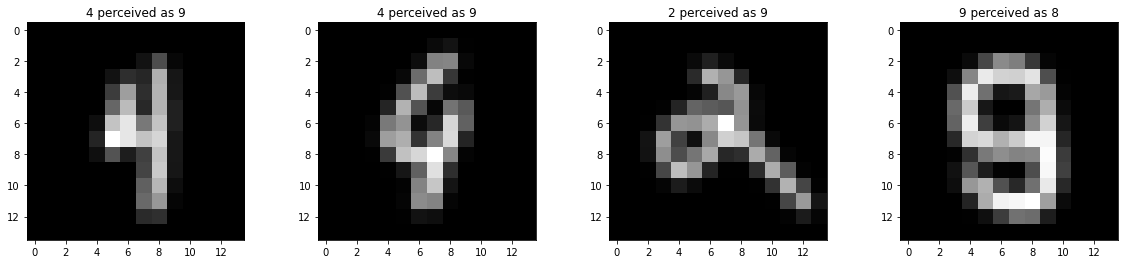

In [22]:
showErrors(KNN_errors, 4, random=False)

## Проблемы

В ходе выполнения работы возникли следующие проблемы

1. Понижение точности при попытке существенно уменьшить размерность входных данных. В результате наибольшая точность была достигнута при при использовании в качестве входных данных исходного изображения $14 \times 14$, преобразованного в столбец размера $1 \times 196$
2. Нехватка оперативной памяти. При использовании большого числа признаков не хватает оперативной памяти в бесплатном Colab. Для решения проблемы тренировочная выборка была сокращена с $60000$ элементов до $12000$ элементов. В теории возможно работать с выборкой длиной $20000$ элементов, но результат будет непредсказуем из-за почти полного заполнения опертивной памяти